<a href="https://colab.research.google.com/github/thejkiran-p/Assessment_PostDoc/blob/main/rayAngiogram_PyTorch_Resnet18_KeyFrame_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Accessing the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Giving the folder location of the dataset 
!ls /content/drive/MyDrive/ImageAnalysis/data_split/

test  train


In [3]:
## Importing required packages
from pyexpat import model
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from PIL import Image
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import Dataset

In [4]:
## Providing Class label information
classes =("keyframe", "non-keyframe")
num_classes = len(classes)
print(num_classes)

2


In [5]:
## Preprocess pipeline, Normailize using ImageNet weights for transfer learning
preprocess = transforms.Compose([
                # convert to PIL image first                 
                transforms.ToPILImage(),
                transforms.Resize((128, 128)),
                transforms.ToTensor(),               
                transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
## Inherit Dataset class for defining custom dataset
class CustomImageDataset(Dataset):

  def __init__(self, npz_file_dir, csv_file_dir, transform=None):
    ## Use pandas to get class label and image info from .npy file format
    self.npz_files = sorted(os.listdir(npz_file_dir))
    self.csv_files = sorted(os.listdir(csv_file_dir))
    self.total_images = []
    self.total_labels = []
    self.transform = transform
    
    for npz, csv in zip(self.npz_files, self.csv_files):
      data = np.load(os.path.join(npz_file_dir, npz))
      labels_df = pd.read_csv(os.path.join(csv_file_dir, csv))
      labels = labels_df["1"]
      images = data[data.files[0]]

      for i, img in enumerate(images):
        img = np.squeeze(img)
        #print(img)
        img_rgb = [img, img, img]
        #print("img shape : ", img.shape)
        img_rgb = np.stack(img_rgb, axis = 0)
        # make image channel last
        img_rgb = np.transpose(img_rgb, (1,2,0))
        #print("img stacked shape : ", img_rgb.shape)
        self.total_images.append(img_rgb)
        self.total_labels.append(labels[i])
    print("Total images shapes : ", np.array(self.total_images).shape)
    print("Total labels shapes : ", np.array(self.total_labels).shape)
    print("non-keyframe-{}, keyframe-{}".format(self.total_labels.count(0), self.total_labels.count(1)))


  ## Total length of the dataset
  def __len__(self):
    return len(self.total_labels)

  ## Each item from dataset indexed by idx
  def __getitem__(self, idx):
    label = self.total_labels[idx]
    # apply preprocessing
    image = self.total_images[idx]
    # print("image in get item: ", image.shape)
    
    if self.transform is not None:
      image = self.transform(image)
      # print("image in get item: ", image.shape)
      return image, label

In [7]:
## File paths of dataset
train_set = CustomImageDataset(npz_file_dir="/content/drive/MyDrive/ImageAnalysis/data_split/train/npz", 
                               csv_file_dir="/content/drive/MyDrive/ImageAnalysis/data_split/train/csv", transform = preprocess)
val_set = CustomImageDataset(npz_file_dir="/content/drive/MyDrive/ImageAnalysis/data_split/test/npz", 
                             csv_file_dir="/content/drive/MyDrive/ImageAnalysis/data_split/test/csv", transform = preprocess)

Total images shapes :  (565, 128, 128, 3)
Total labels shapes :  (565,)
non-keyframe-240, keyframe-325
Total images shapes :  (129, 128, 128, 3)
Total labels shapes :  (129,)
non-keyframe-60, keyframe-69


In [8]:
# creating dataloader from dataset, here we specify batch_size and shuffle, and no of threads to work on the data
trainloader=torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True,num_workers=2)
valloader=torch.utils.data.DataLoader(val_set,batch_size=64,shuffle=False,num_workers=2)

In [9]:
# model is taken from torch hub with pretrained weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# last fully connected layer is overwritten with custom Linear layer
model.fc = nn.Linear(512, num_classes)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
## Checking availability of GPU
torch.cuda.is_available()

True

In [11]:
## Accesssing GPU based on its availability; Calculating loss and optimizing the model
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [12]:
## Provides summary of the model
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [13]:
## Get details of parameters in the model
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

11177538

In [14]:
## training the model and obtain its accuracy and loss
train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):
    
    inputs,labels=data[0].float().to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    #Replaces pow(2.0) with abs() for L1 regularization
    
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [15]:
## Calculate the test dataset accuracy and loss
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(valloader):
      images,labels=data[0].float().to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(valloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))

In [16]:
## Iterating the model or train and test dataset
epochs=100

for epoch in range(1,epochs+1):
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 9/9 [00:01<00:00,  7.34it/s]


Train Loss: 7.742 | Accuracy: 75.929


100%|██████████| 3/3 [00:00<00:00,  9.73it/s]


Test Loss: 0.570 | Accuracy: 53.488

Epoch : 2


100%|██████████| 9/9 [00:01<00:00,  8.47it/s]


Train Loss: 7.421 | Accuracy: 94.513


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


Test Loss: 0.611 | Accuracy: 55.814

Epoch : 3


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


Train Loss: 7.320 | Accuracy: 98.230


100%|██████████| 3/3 [00:00<00:00, 10.59it/s]


Test Loss: 0.749 | Accuracy: 53.488

Epoch : 4


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


Train Loss: 7.293 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


Test Loss: 0.760 | Accuracy: 53.488

Epoch : 5


100%|██████████| 9/9 [00:01<00:00,  8.77it/s]


Train Loss: 7.282 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.68it/s]


Test Loss: 0.789 | Accuracy: 53.488

Epoch : 6


100%|██████████| 9/9 [00:01<00:00,  8.69it/s]


Train Loss: 7.269 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


Test Loss: 0.964 | Accuracy: 53.488

Epoch : 7


100%|██████████| 9/9 [00:01<00:00,  8.59it/s]


Train Loss: 7.260 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.64it/s]


Test Loss: 1.065 | Accuracy: 53.488

Epoch : 8


100%|██████████| 9/9 [00:01<00:00,  8.36it/s]


Train Loss: 7.267 | Accuracy: 98.230


100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


Test Loss: 1.072 | Accuracy: 53.488

Epoch : 9


100%|██████████| 9/9 [00:01<00:00,  7.91it/s]


Train Loss: 7.258 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.16it/s]


Test Loss: 1.140 | Accuracy: 53.488

Epoch : 10


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


Train Loss: 7.256 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.86it/s]


Test Loss: 1.110 | Accuracy: 53.488

Epoch : 11


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


Train Loss: 7.255 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


Test Loss: 1.145 | Accuracy: 53.488

Epoch : 12


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


Train Loss: 7.254 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


Test Loss: 1.116 | Accuracy: 53.488

Epoch : 13


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


Train Loss: 7.248 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


Test Loss: 1.122 | Accuracy: 53.488

Epoch : 14


100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 7.238 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


Test Loss: 1.266 | Accuracy: 53.488

Epoch : 15


100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


Train Loss: 7.244 | Accuracy: 98.230


100%|██████████| 3/3 [00:00<00:00,  9.97it/s]


Test Loss: 1.212 | Accuracy: 53.488

Epoch : 16


100%|██████████| 9/9 [00:01<00:00,  8.58it/s]


Train Loss: 7.233 | Accuracy: 99.115


100%|██████████| 3/3 [00:00<00:00,  9.93it/s]


Test Loss: 1.184 | Accuracy: 53.488

Epoch : 17


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 7.232 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


Test Loss: 1.148 | Accuracy: 53.488

Epoch : 18


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


Train Loss: 7.235 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.15it/s]


Test Loss: 1.229 | Accuracy: 53.488

Epoch : 19


100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


Train Loss: 7.231 | Accuracy: 98.230


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


Test Loss: 1.271 | Accuracy: 53.488

Epoch : 20


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


Train Loss: 7.228 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.38it/s]


Test Loss: 1.305 | Accuracy: 53.488

Epoch : 21


100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


Train Loss: 7.222 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


Test Loss: 1.235 | Accuracy: 53.488

Epoch : 22


100%|██████████| 9/9 [00:01<00:00,  8.71it/s]


Train Loss: 7.219 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


Test Loss: 1.298 | Accuracy: 53.488

Epoch : 23


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


Train Loss: 7.214 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


Test Loss: 1.253 | Accuracy: 53.488

Epoch : 24


100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


Train Loss: 7.212 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


Test Loss: 1.296 | Accuracy: 53.488

Epoch : 25


100%|██████████| 9/9 [00:01<00:00,  8.71it/s]


Train Loss: 7.211 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


Test Loss: 1.236 | Accuracy: 53.488

Epoch : 26


100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


Train Loss: 7.211 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.50it/s]


Test Loss: 1.168 | Accuracy: 53.488

Epoch : 27


100%|██████████| 9/9 [00:01<00:00,  8.31it/s]


Train Loss: 7.208 | Accuracy: 98.230


100%|██████████| 3/3 [00:00<00:00, 10.61it/s]


Test Loss: 1.221 | Accuracy: 53.488

Epoch : 28


100%|██████████| 9/9 [00:01<00:00,  8.63it/s]


Train Loss: 7.202 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.30it/s]


Test Loss: 1.283 | Accuracy: 53.488

Epoch : 29


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 7.201 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]


Test Loss: 1.222 | Accuracy: 53.488

Epoch : 30


100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


Train Loss: 7.201 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.32it/s]


Test Loss: 1.295 | Accuracy: 53.488

Epoch : 31


100%|██████████| 9/9 [00:01<00:00,  8.57it/s]


Train Loss: 7.194 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.78it/s]


Test Loss: 1.352 | Accuracy: 53.488

Epoch : 32


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


Train Loss: 7.191 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


Test Loss: 1.282 | Accuracy: 53.488

Epoch : 33


100%|██████████| 9/9 [00:01<00:00,  8.86it/s]


Train Loss: 7.190 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]


Test Loss: 1.240 | Accuracy: 53.488

Epoch : 34


100%|██████████| 9/9 [00:01<00:00,  8.69it/s]


Train Loss: 7.190 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


Test Loss: 1.283 | Accuracy: 53.488

Epoch : 35


100%|██████████| 9/9 [00:01<00:00,  8.80it/s]


Train Loss: 7.184 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.69it/s]


Test Loss: 1.282 | Accuracy: 53.488

Epoch : 36


100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


Train Loss: 7.188 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.66it/s]


Test Loss: 1.205 | Accuracy: 53.488

Epoch : 37


100%|██████████| 9/9 [00:01<00:00,  8.66it/s]


Train Loss: 7.178 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


Test Loss: 1.186 | Accuracy: 53.488

Epoch : 38


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


Train Loss: 7.182 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.68it/s]


Test Loss: 1.162 | Accuracy: 53.488

Epoch : 39


100%|██████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 7.171 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


Test Loss: 1.256 | Accuracy: 53.488

Epoch : 40


100%|██████████| 9/9 [00:01<00:00,  8.78it/s]


Train Loss: 7.169 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


Test Loss: 1.273 | Accuracy: 53.488

Epoch : 41


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 7.169 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.75it/s]


Test Loss: 1.270 | Accuracy: 53.488

Epoch : 42


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 7.163 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


Test Loss: 1.302 | Accuracy: 53.488

Epoch : 43


100%|██████████| 9/9 [00:01<00:00,  8.70it/s]


Train Loss: 7.159 | Accuracy: 99.292


100%|██████████| 3/3 [00:00<00:00, 10.81it/s]


Test Loss: 1.316 | Accuracy: 53.488

Epoch : 44


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 7.163 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.52it/s]


Test Loss: 1.241 | Accuracy: 53.488

Epoch : 45


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 7.156 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.36it/s]


Test Loss: 1.208 | Accuracy: 53.488

Epoch : 46


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


Train Loss: 7.152 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


Test Loss: 1.265 | Accuracy: 53.488

Epoch : 47


100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


Train Loss: 7.151 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.50it/s]


Test Loss: 1.284 | Accuracy: 53.488

Epoch : 48


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


Train Loss: 7.148 | Accuracy: 99.115


100%|██████████| 3/3 [00:00<00:00, 10.78it/s]


Test Loss: 1.287 | Accuracy: 53.488

Epoch : 49


100%|██████████| 9/9 [00:01<00:00,  8.81it/s]


Train Loss: 7.146 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


Test Loss: 1.335 | Accuracy: 53.488

Epoch : 50


100%|██████████| 9/9 [00:01<00:00,  8.27it/s]


Train Loss: 7.141 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.36it/s]


Test Loss: 1.309 | Accuracy: 53.488

Epoch : 51


100%|██████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 7.141 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


Test Loss: 1.291 | Accuracy: 53.488

Epoch : 52


100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


Train Loss: 7.141 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


Test Loss: 1.365 | Accuracy: 53.488

Epoch : 53


100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


Train Loss: 7.136 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


Test Loss: 1.353 | Accuracy: 53.488

Epoch : 54


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


Train Loss: 7.136 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


Test Loss: 1.291 | Accuracy: 53.488

Epoch : 55


100%|██████████| 9/9 [00:01<00:00,  8.52it/s]


Train Loss: 7.128 | Accuracy: 99.292


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


Test Loss: 1.236 | Accuracy: 53.488

Epoch : 56


100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


Train Loss: 7.123 | Accuracy: 99.292


100%|██████████| 3/3 [00:00<00:00, 10.38it/s]


Test Loss: 1.270 | Accuracy: 53.488

Epoch : 57


100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


Train Loss: 7.126 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


Test Loss: 1.270 | Accuracy: 53.488

Epoch : 58


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 7.120 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.43it/s]


Test Loss: 1.324 | Accuracy: 53.488

Epoch : 59


100%|██████████| 9/9 [00:01<00:00,  8.59it/s]


Train Loss: 7.114 | Accuracy: 99.469


100%|██████████| 3/3 [00:00<00:00, 10.04it/s]


Test Loss: 1.354 | Accuracy: 53.488

Epoch : 60


100%|██████████| 9/9 [00:01<00:00,  8.46it/s]


Train Loss: 7.119 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.38it/s]


Test Loss: 1.331 | Accuracy: 53.488

Epoch : 61


100%|██████████| 9/9 [00:01<00:00,  8.28it/s]


Train Loss: 7.120 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


Test Loss: 1.338 | Accuracy: 53.488

Epoch : 62


100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


Train Loss: 7.111 | Accuracy: 99.115


100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


Test Loss: 1.291 | Accuracy: 53.488

Epoch : 63


100%|██████████| 9/9 [00:01<00:00,  8.75it/s]


Train Loss: 7.107 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


Test Loss: 1.244 | Accuracy: 53.488

Epoch : 64


100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


Train Loss: 7.110 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


Test Loss: 1.257 | Accuracy: 53.488

Epoch : 65


100%|██████████| 9/9 [00:01<00:00,  8.41it/s]


Train Loss: 7.103 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


Test Loss: 1.243 | Accuracy: 53.488

Epoch : 66


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


Train Loss: 7.108 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00,  9.99it/s]


Test Loss: 1.310 | Accuracy: 53.488

Epoch : 67


100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 7.103 | Accuracy: 98.230


100%|██████████| 3/3 [00:00<00:00,  9.96it/s]


Test Loss: 1.301 | Accuracy: 53.488

Epoch : 68


100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


Train Loss: 7.099 | Accuracy: 98.230


100%|██████████| 3/3 [00:00<00:00, 10.06it/s]


Test Loss: 1.352 | Accuracy: 53.488

Epoch : 69


100%|██████████| 9/9 [00:01<00:00,  8.66it/s]


Train Loss: 7.092 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]


Test Loss: 1.355 | Accuracy: 53.488

Epoch : 70


100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


Train Loss: 7.091 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.66it/s]


Test Loss: 1.370 | Accuracy: 53.488

Epoch : 71


100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Train Loss: 7.087 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


Test Loss: 1.356 | Accuracy: 53.488

Epoch : 72


100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


Train Loss: 7.086 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


Test Loss: 1.375 | Accuracy: 53.488

Epoch : 73


100%|██████████| 9/9 [00:01<00:00,  8.63it/s]


Train Loss: 7.083 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.49it/s]


Test Loss: 1.350 | Accuracy: 53.488

Epoch : 74


100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


Train Loss: 7.082 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


Test Loss: 1.362 | Accuracy: 53.488

Epoch : 75


100%|██████████| 9/9 [00:01<00:00,  8.58it/s]


Train Loss: 7.078 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]


Test Loss: 1.276 | Accuracy: 53.488

Epoch : 76


100%|██████████| 9/9 [00:01<00:00,  8.70it/s]


Train Loss: 7.076 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


Test Loss: 1.287 | Accuracy: 53.488

Epoch : 77


100%|██████████| 9/9 [00:01<00:00,  8.43it/s]


Train Loss: 7.074 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.27it/s]


Test Loss: 1.315 | Accuracy: 53.488

Epoch : 78


100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


Train Loss: 7.071 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]


Test Loss: 1.366 | Accuracy: 53.488

Epoch : 79


100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 7.067 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.84it/s]


Test Loss: 1.342 | Accuracy: 53.488

Epoch : 80


100%|██████████| 9/9 [00:01<00:00,  8.58it/s]


Train Loss: 7.067 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


Test Loss: 1.339 | Accuracy: 53.488

Epoch : 81


100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


Train Loss: 7.061 | Accuracy: 99.292


100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


Test Loss: 1.360 | Accuracy: 53.488

Epoch : 82


100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


Train Loss: 7.059 | Accuracy: 99.115


100%|██████████| 3/3 [00:00<00:00, 10.36it/s]


Test Loss: 1.353 | Accuracy: 53.488

Epoch : 83


100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


Train Loss: 7.059 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


Test Loss: 1.383 | Accuracy: 53.488

Epoch : 84


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


Train Loss: 7.054 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


Test Loss: 1.364 | Accuracy: 53.488

Epoch : 85


100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


Train Loss: 7.053 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


Test Loss: 1.353 | Accuracy: 53.488

Epoch : 86


100%|██████████| 9/9 [00:01<00:00,  8.47it/s]


Train Loss: 7.052 | Accuracy: 98.584


100%|██████████| 3/3 [00:00<00:00, 10.40it/s]


Test Loss: 1.337 | Accuracy: 53.488

Epoch : 87


100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


Train Loss: 7.050 | Accuracy: 98.053


100%|██████████| 3/3 [00:00<00:00, 10.45it/s]


Test Loss: 1.340 | Accuracy: 53.488

Epoch : 88


100%|██████████| 9/9 [00:01<00:00,  8.41it/s]


Train Loss: 7.047 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.66it/s]


Test Loss: 1.426 | Accuracy: 53.488

Epoch : 89


100%|██████████| 9/9 [00:01<00:00,  8.59it/s]


Train Loss: 7.045 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


Test Loss: 1.398 | Accuracy: 53.488

Epoch : 90


100%|██████████| 9/9 [00:01<00:00,  8.38it/s]


Train Loss: 7.040 | Accuracy: 99.115


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


Test Loss: 1.408 | Accuracy: 53.488

Epoch : 91


100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


Train Loss: 7.035 | Accuracy: 99.115


100%|██████████| 3/3 [00:00<00:00, 10.52it/s]


Test Loss: 1.315 | Accuracy: 53.488

Epoch : 92


100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


Train Loss: 7.037 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.42it/s]


Test Loss: 1.333 | Accuracy: 53.488

Epoch : 93


100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


Train Loss: 7.031 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.86it/s]


Test Loss: 1.369 | Accuracy: 53.488

Epoch : 94


100%|██████████| 9/9 [00:01<00:00,  8.68it/s]


Train Loss: 7.032 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


Test Loss: 1.444 | Accuracy: 53.488

Epoch : 95


100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


Train Loss: 7.028 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.09it/s]


Test Loss: 1.388 | Accuracy: 53.488

Epoch : 96


100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


Train Loss: 7.025 | Accuracy: 98.938


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


Test Loss: 1.452 | Accuracy: 53.488

Epoch : 97


100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


Train Loss: 7.020 | Accuracy: 99.115


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


Test Loss: 1.444 | Accuracy: 53.488

Epoch : 98


100%|██████████| 9/9 [00:01<00:00,  8.22it/s]


Train Loss: 7.020 | Accuracy: 99.292


100%|██████████| 3/3 [00:00<00:00, 10.15it/s]


Test Loss: 1.443 | Accuracy: 53.488

Epoch : 99


100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


Train Loss: 7.017 | Accuracy: 98.761


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


Test Loss: 1.401 | Accuracy: 53.488

Epoch : 100


100%|██████████| 9/9 [00:01<00:00,  8.53it/s]


Train Loss: 7.015 | Accuracy: 98.407


100%|██████████| 3/3 [00:00<00:00, 10.47it/s]

Test Loss: 1.383 | Accuracy: 53.488


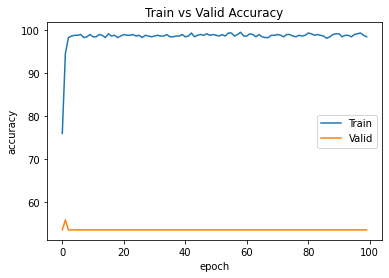

In [17]:
#plot accuracy

plt.plot(train_accu,'-')
plt.plot(eval_accu,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

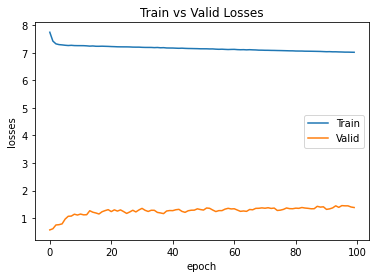

In [18]:
#plot losses

plt.plot(train_losses,'-')
plt.plot(eval_losses,'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()